In [1]:
%matplotlib inline
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
from scipy.spatial.transform import Rotation

In [2]:
from IPython.core.debugger import Pdb

In [3]:
from IPython.display import clear_output
clear_output()

In [4]:
model = mujoco.MjModel.from_xml_path("joint_based_finger.xml")
data = mujoco.MjData(model)

In [5]:
duration = 6
framerate = 60 # fps

In [6]:
print('default gravity', model.opt.gravity)
model.opt.gravity = (0, 0, 10)
print('flipped gravity', model.opt.gravity)

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False

data.ctrl = [0, 0, 0]

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    data.ctrl = [1.57, 0.52, 0]
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option, camera="scene_view")
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

default gravity [ 0.    0.   -9.81]
flipped gravity [ 0.  0. 10.]


## Learning to draw traces/objects in the scene
Let's try to draw the frames of specific bodies provided. The default one only draws all frames which is not good

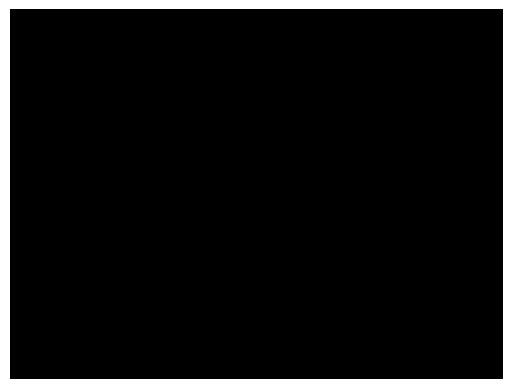

In [173]:
# Static using matplotlib

with mujoco.Renderer(model) as renderer:
    renderer.disable_segmentation_rendering()
    # reset the scene
    renderer.update_scene(data, camera="scene_view")

    # Render the camera view and overlay the projected corner coordinates.
    pixels = renderer.render()
    fig, ax = plt.subplots(1, 1)
    ax.imshow(pixels)
    
    ax.set_axis_off()

In [7]:
def add_arrow(scene, point1, point2, rgba):
  """Adds an arrow to an mjvScene.

  point1 and point2 are in world frame
  """
  if scene.ngeom >= scene.maxgeom:
    return
  scene.ngeom += 1  # increment ngeom
  # initialise a new arrow, add it to the scene using mjv_connector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_ARROW, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))
  mujoco.mjv_connector(scene.geoms[scene.ngeom-1],
                       int(mujoco.mjtGeom.mjGEOM_ARROW), 0.001,
                       point1, point2)

def draw_coord_frame_for_body(scene, body_name):
    body_id = model.body(body_name).id
    rot_mat = data.xmat[body_id].reshape(3,3)
    length_scale = 0.05

    dx = rot_mat[:, 0]*length_scale
    dy = rot_mat[:, 1]*length_scale
    dz = rot_mat[:, 2]*length_scale
    
    o = data.xpos[body_id]

    # x - red, y - green, z - blue
    red = np.array([1, 0, 0, 1])
    blue = np.array([0, 0, 1, 1])
    green = np.array([0, 1, 0, 1])
  
    add_arrow(scene, o, o+dx, red)
    add_arrow(scene, o, o+dy, green)
    add_arrow(scene, o, o+dz, blue)

def draw_coord_frame(scene, o, rot_mat):

    length_scale = 0.05

    dx = rot_mat[:, 0]*length_scale
    dy = rot_mat[:, 1]*length_scale
    dz = rot_mat[:, 2]*length_scale

    # x - red, y - green, z - blue
    red = np.array([1, 0, 0, 1])
    blue = np.array([0, 0, 1, 1])
    green = np.array([0, 1, 0, 1])
  
    add_arrow(scene, o, o+dx, red)
    add_arrow(scene, o, o+dy, green)
    add_arrow(scene, o, o+dz, blue)

In [8]:
# Dynamic using renderer
body_name = "dp_adapter"
frames = []
mujoco.mj_resetData(model, data)
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

velocities = []
with mujoco.Renderer(model, width=640, height=480) as renderer:
    
    pixels = renderer.render()
    data.ctrl = [1.57, 0, 0]

    while data.time < duration:
        mujoco.mj_step(model, data)
        act = data.actuator("mcp")

        vel = act.velocity[0]
        velocities.append(vel)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, scene_option=scene_option, camera="scene_view")
            
            # Add Frames
            draw_coord_frame_for_body(renderer.scene, "base")
            draw_coord_frame_for_body(renderer.scene, "pp_link")

            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

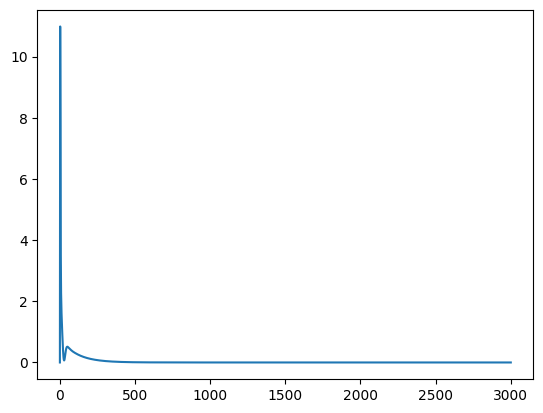

In [10]:
# Plot velocity plot for the control
plt.plot(np.arange(len(velocities)), velocities)

## Idea
For each of the joints, apply control input, wait for the motion to complete, and then get the orientation of the joint wrt the relative body frame. It should change by exactly the control joint amount. Plot the control value, orientation value, and delta

In [11]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.labelsize'] = 'small'

In [12]:
actuators_and_body_pairs = {
    "mcp": ("base", "pp_link"),
    "adb": ("base", "dp_adapter"),
    "pip": ("pp_link", "mp_link"),
    "dip": ("mp_link", "dp_adapter")
}

In [13]:
def get_euler_rotation_wrt_start(m, d, b2, C_I_b20):
    b2_id = m.body(b2).id
    C_I_B2 = Rotation.from_matrix(d.xmat[b2_id].reshape(3,3))
 
    C_B20_B2_computed = C_I_b20.inv()*C_I_B2;

    theta = np.arccos(C_B20_B2_computed.as_quat()[-1]) * 2
    
    return theta, None

def add_annotations(renderer, d, b1, b2, arrows=None):
    
    draw_coord_frame_for_body(renderer.scene, b1)
    draw_coord_frame_for_body(renderer.scene, b2)

    if not arrows:
        return renderer.render()
    for arrow in arrows:
        o, R = arrow
        draw_coord_frame(renderer.scene, o, R)
    return renderer.render()

In [14]:
def run_exp_for_single_actuator(m, d, renderer, act_name, st, end, camera):
    rng = np.arange(st, end, 0.1 if st < end else -0.1) # Steps of 0.1 radians

    actuator = d.actuator(act_name)
    act_id = actuator.id

    p_controls = []
    p_theta = []
    frames = []

    b1, b2 = actuators_and_body_pairs[act_name]

    # Align the axis first and then get the angle (see rotation example below)
    # Compute and save C_I_B20
    b2_id = m.body(b2).id
    C_I_b20 = Rotation.from_matrix(d.xmat[b2_id].reshape(3,3))

    for u in rng:
        ctl = np.zeros(3)
        ctl[act_id] = u
        d.ctrl = ctl

        mujoco.mj_step(m, d)
        # Keep stepping until the actuator stops moving
        while not np.isclose(actuator.velocity[0], 0):
            mujoco.mj_step(m, d)
            t = data.tendon("adb_actuate_tendon")
            
        renderer.update_scene(data, scene_option=scene_option, camera=camera) 

        # Now it has reached the positions (supposedly). Take Transformation
        theta, corrected_frame = get_euler_rotation_wrt_start(m, d, b2, C_I_b20)

        p_controls.append(u)
        p_theta.append(theta)
        pixels = add_annotations(renderer, d, b1, b2)

        frames.append(pixels)

    # Thetas are in all three axes. Plot them separately.b
    p_controls = np.array(p_controls).reshape((-1, 1))
    p_theta = np.array(p_theta).reshape((-1, 1))

    return p_controls, p_theta, frames

In [17]:
# MAIN LOOP

def exp_wrapper(name, st, end, camera="scene_view"):
    ticks = np.arange(st-0.1, end+0.1, 0.1) if end > st else np.arange(end-0.1, st+0.1, 0.1)
    
    mujoco.mj_resetData(model, data)
    mujoco.mj_step(model, data)
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
       
    with mujoco.Renderer(model, width=640, height=480) as renderer:
        pixels = renderer.render()    
        p_controls, p_theta, frames = run_exp_for_single_actuator(model, data, renderer, name, st, end, camera)

    plt.imshow(frames[0])
    
    fig, ax = plt.subplots(3, 1, figsize=(8, 12))
    ax = ax.reshape((-1, 1))
    fig.suptitle(f"Actuator: {name}")
    ax[0, 0].plot(np.arange(len(p_controls)), p_controls)
    ax[0, 0].set_title("Control Input")
    ax[0, 0].set_yticks(ticks)
    
    
    ax[1, 0].plot(p_controls, p_theta[:, 0])
    ax[1, 0].set_title("Pose Angle")
    ax[1, 0].set_xlabel("u")
    ax[1, 0].set_ylabel("theta")
    ax[1, 0].set_yticks(ticks)
    
    # Next is the difference between control and theta
    delta = p_controls.reshape((-1, 1)) - p_theta
    ax[2, 0].plot(np.arange(len(p_controls)), delta[:, 0])
    ax[2, 0].set_title("Control vs Angle")
    ax[2, 0].set_ylabel("dtheta")
    ax[2, 0].set_yticks(ticks)

    return frames

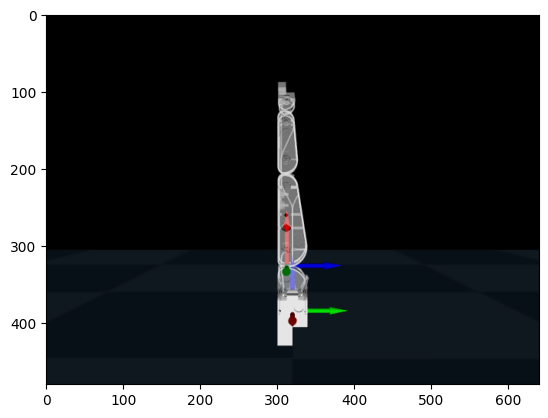

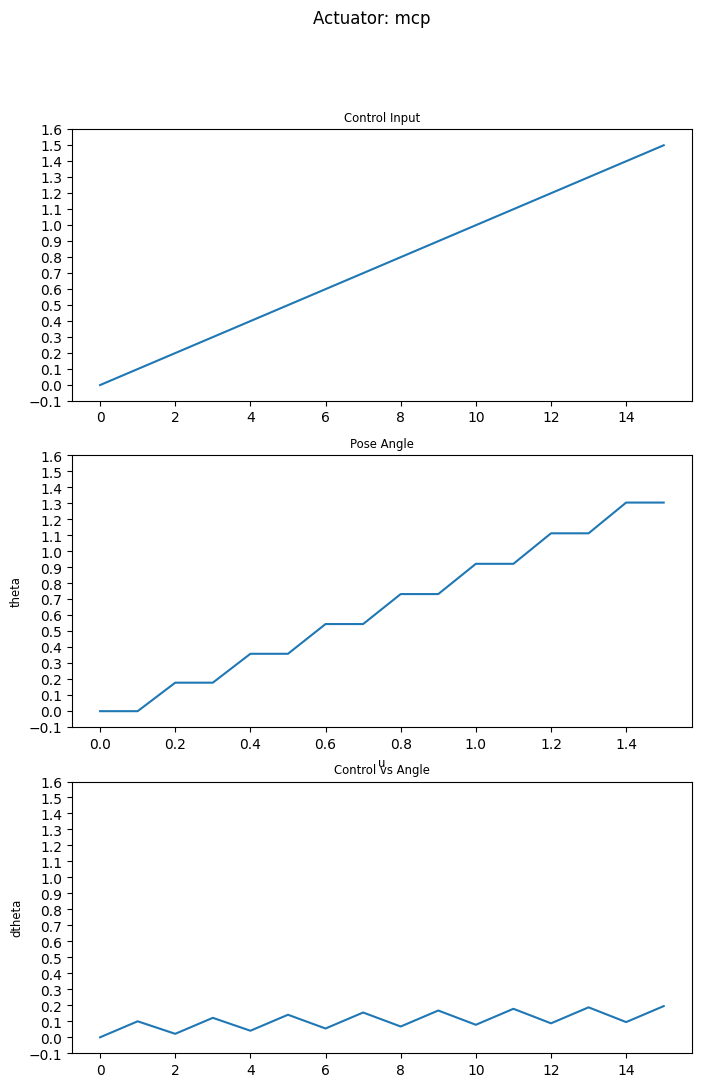

In [19]:
f_mcp = exp_wrapper("mcp", 0, np.pi/2, "side")

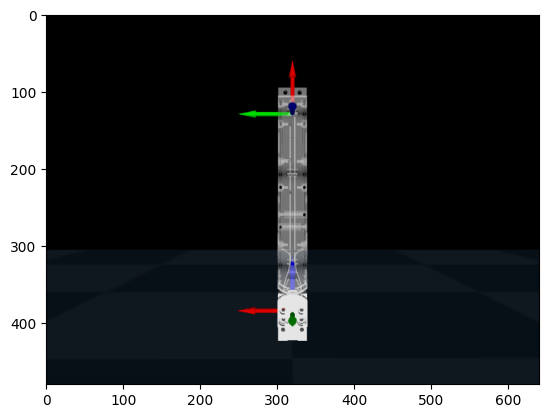

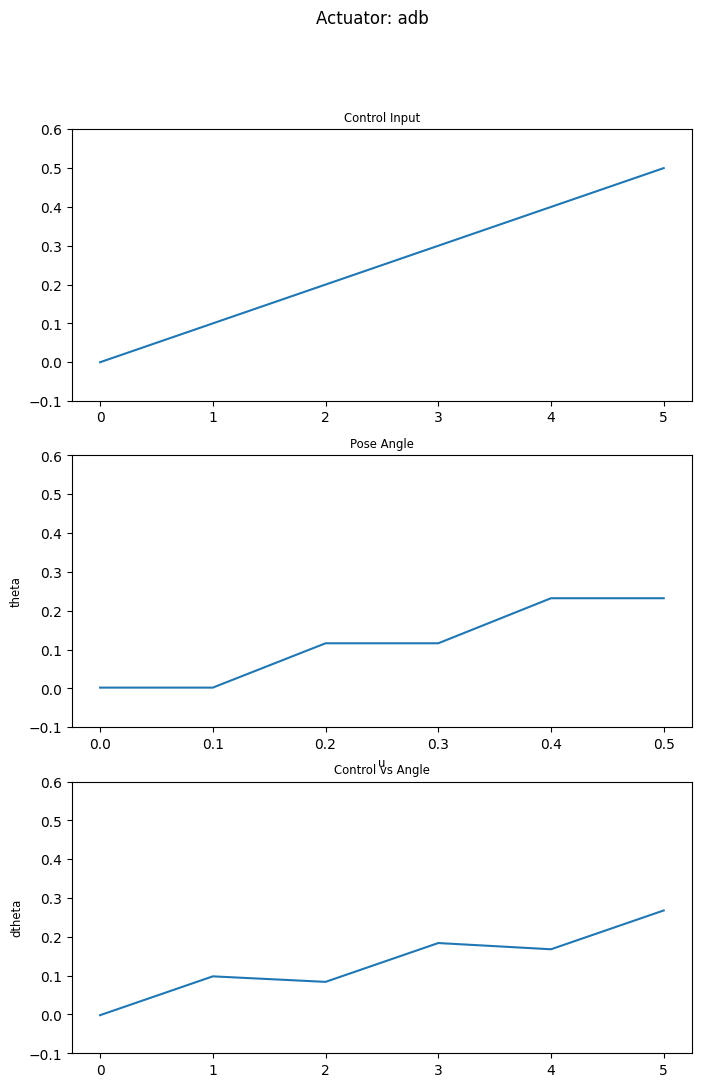

In [20]:
f_adb_p = exp_wrapper("adb", 0, np.pi/6, "front")


In [21]:
media.show_video(f_adb_p, fps=10)

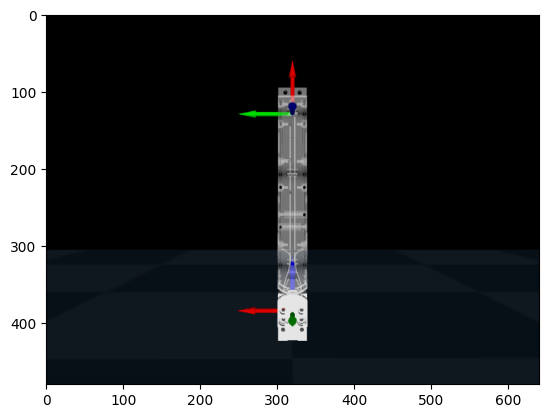

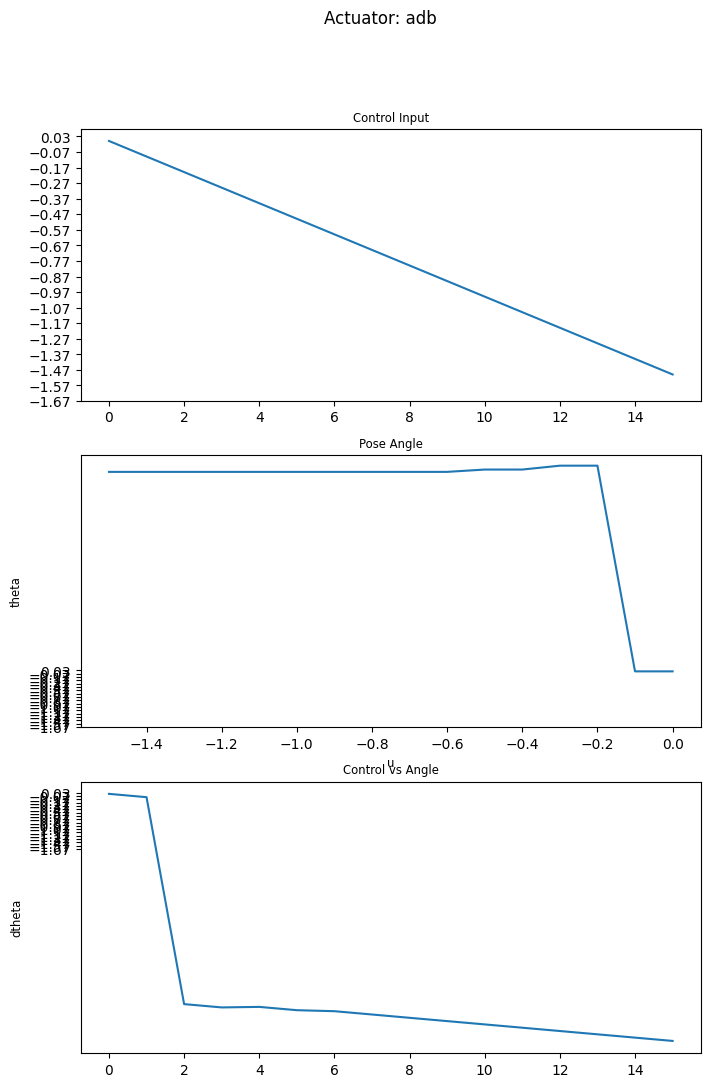

In [22]:
f_adb_neg = exp_wrapper("adb", 0, -np.pi/2, "front")

In [23]:
media.show_video(f_adb_neg, fps=10)

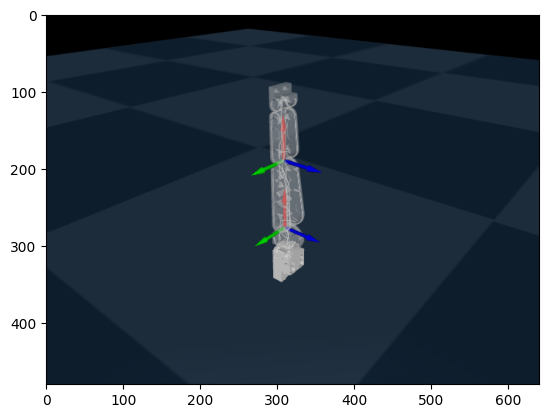

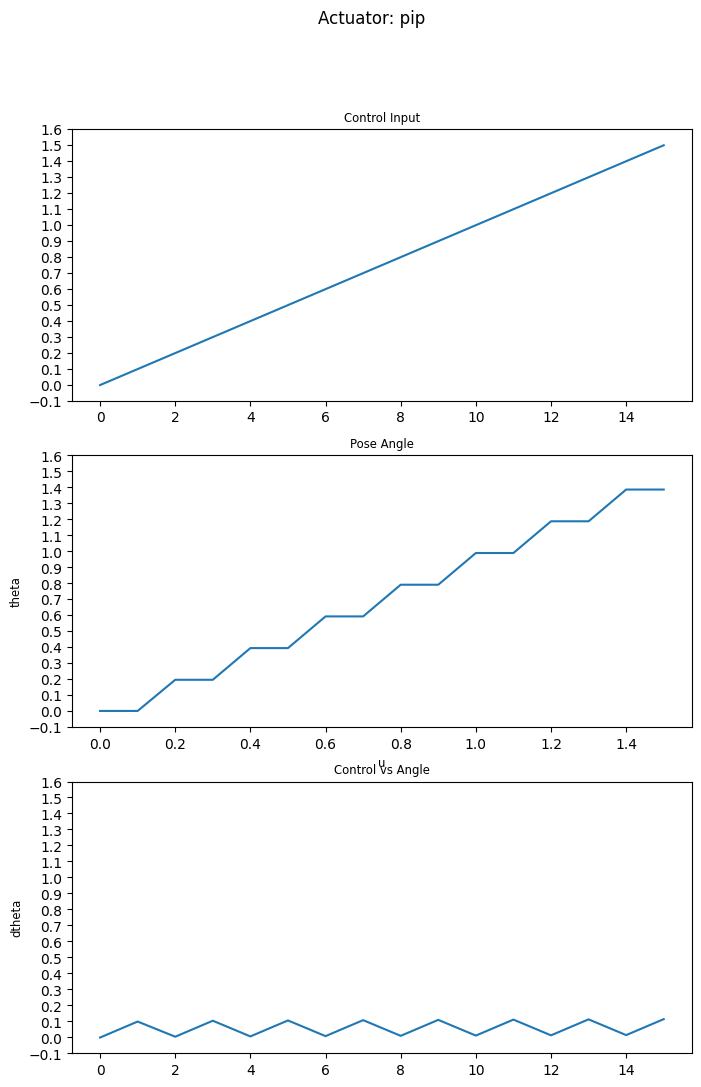

In [24]:
f_pip = exp_wrapper("pip", 0, np.pi/2)

In [25]:
media.show_video(f_pip, fps=10)

---

## Rotation Matrices Doubts

In [275]:
from mpl_toolkits.mplot3d import Axes3D

In [290]:
def eltX(t):
    return Rotation.from_matrix(np.array([1, 0, 0, 0, np.cos(t), -np.sin(t), 0, np.sin(t), np.cos(t)]).reshape((3,3)))

def plot_frame(ax, rotation_matrix, origin=np.zeros(3), length=1.0, label=None):
    """
    Plots a 3D frame on a Matplotlib axis using a rotation matrix.
    
    Parameters:
    ax (Axes3D): Matplotlib 3D axis object.
    rotation_matrix (numpy.ndarray): 3x3 rotation matrix.
    origin (numpy.ndarray): 3D coordinates of the origin of the frame (default: [0, 0, 0]).
    length (float): Length of the frame arrows (default: 1.0).
    """
    # Ensure the inputs are numpy arrays
    origin = np.array(origin)
    rotation_matrix = np.array(rotation_matrix)
    
    # Extract the frame axes
    x_axis = rotation_matrix[:, 0]
    y_axis = rotation_matrix[:, 1]
    z_axis = rotation_matrix[:, 2]
    
    # Scale the axes by the specified length
    x_axis = origin + length * x_axis
    y_axis = origin + length * y_axis
    z_axis = origin + length * z_axis
    
    # Plot the axes
    ax.quiver(*origin, *(x_axis - origin), color='r', label='x-axis')
    ax.quiver(*origin, *(y_axis - origin), color='g', label='y-axis')
    ax.quiver(*origin, *(z_axis - origin), color='b', label='z-axis')

    # Add a label at the origin
    if label:
        ax.text(*origin, label, color='black', fontsize=10)

In [299]:
theta = np.pi/4

C_B20_B2 = eltX(theta)

C_B1_B20 = Rotation.from_matrix(np.array([0, 0, 1, 1, 0, 0, 0, 1, 0]).reshape((3,3)))

# Inertial rotations given from mujoco but we'll work backwards for this example.
C_I_I = Rotation.from_matrix(np.eye(3))
C_I_B1 = Rotation.from_matrix(np.eye(3))
C_I_B20 = C_I_B1*C_B1_B20
C_I_B2 = C_I_B1*C_B1_B20*C_B20_B2;

C_B20_B2_computed = C_I_B20.inv()*C_I_B2

In [302]:
C_B20_B2_computed.as_euler("xyz", degrees=True)

array([45.,  0.,  0.])

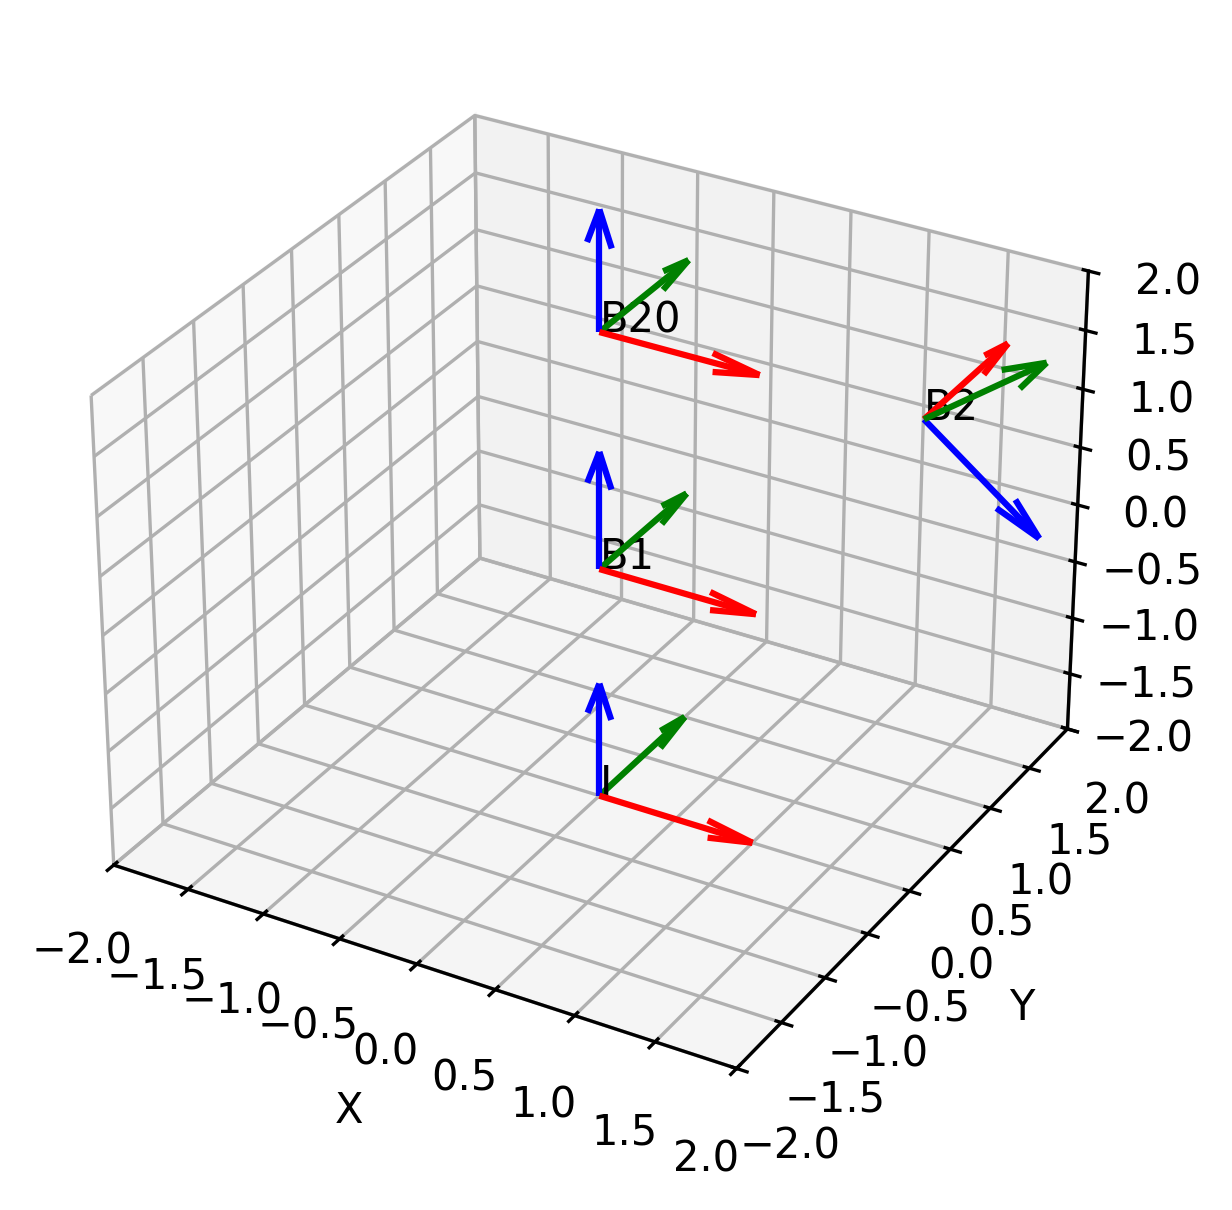

In [300]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


# Plot in the inertial frame
plot_frame(ax, C_I_I.as_matrix(), origin=[0, 0, -2], label="I")

plot_frame(ax, C_I_B1.as_matrix(), origin=[0, 0, 0], label="B1")

plot_frame(ax, C_I_B1.as_matrix(), origin=[0, 0, 2], label="B20")

plot_frame(ax, C_I_B2.as_matrix(), origin=[2, 0, 2], label="B2")

## Getting tendon lengths and properties to debug

In [556]:
t = data.tendon("adb_actuate_tendon")
t

<_MjDataTendonViews
  J: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  J_colind: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)
  J_rowadr: array([0], dtype=int32)
  J_rownnz: array([0], dtype=int32)
  id: 1
  length: array([0.])
  name: 'adb_actuate_tendon'
  velocity: array([0.])
  wrapadr: array([0], dtype=int32)
  wrapnum: array([0], dtype=int32)
>